# Final Project: Credit Card Default Prediction 
Author: Tobby Yang, Ivy Chen, Jackson Fang

## Data Preprocessing

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
data = pd.read_csv('lending_club_loan_two.csv')

In [3]:
data.head()

,loan_amnt,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,...,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,application_type,mort_acc,pub_rec_bankruptcies,address
0,10000.0,36 months,11.44,329.48,B,B4,Marketing,10+ years,RENT,117000.0,...,16.0,0.0,36369.0,41.8,25.0,w,INDIVIDUAL,0.0,0.0,"0174 Michelle Gateway\r\nMendozaberg, OK 22690"
1,8000.0,36 months,11.99,265.68,B,B5,Credit analyst,4 years,MORTGAGE,65000.0,...,17.0,0.0,20131.0,53.3,27.0,f,INDIVIDUAL,3.0,0.0,"1076 Carney Fort Apt. 347\r\nLoganmouth, SD 05113"
2,15600.0,36 months,10.49,506.97,B,B3,Statistician,< 1 year,RENT,43057.0,...,13.0,0.0,11987.0,92.2,26.0,f,INDIVIDUAL,0.0,0.0,"87025 Mark Dale Apt. 269\r\nNew Sabrina, WV 05113"
3,7200.0,36 months,6.49,220.65,A,A2,Client Advocate,6 years,RENT,54000.0,...,6.0,0.0,5472.0,21.5,13.0,f,INDIVIDUAL,0.0,0.0,"823 Reid Ford\r\nDelacruzside, MA 00813"
4,24375.0,60 months,17.27,609.33,C,C5,Destiny Management Inc.,9 years,MORTGAGE,55000.0,...,13.0,0.0,24584.0,69.8,43.0,f,INDIVIDUAL,1.0,0.0,"679 Luna Roads\r\nGreggshire, VA 11650"


#### Check emp_title variable

In [4]:
data.emp_title.nunique()

173105

Since there are too many job titles, we need to drop it to avoid too many binary variables.

In [5]:
data.drop('emp_title', axis=1, inplace=True)

#### Check emp_length

In [6]:
# Check unique values
print(data['emp_length'].value_counts(dropna=False))


emp_length
10+ years    126041
2 years       35827
< 1 year      31725
3 years       31665
5 years       26495
1 year        25882
4 years       23952
6 years       20841
7 years       20819
8 years       19168
NaN           18301
9 years       15314
Name: count, dtype: int64


In [7]:
# Clean and convert emp_length to ordered categorical type
emp_order = ['< 1 year', '2 years', '3 years', '4 years', '5 years',
             '6 years', '7 years', '8 years', '9 years', '10+ years']

data['emp_length'] = pd.Categorical(data['emp_length'], categories=emp_order, ordered=True)


In [8]:
print(data['loan_status'].value_counts())


loan_status
Fully Paid     318357
Charged Off     77673
Name: count, dtype: int64


In [9]:
# Example: Define "Good" as fully paid or current
good_status = ['Fully Paid']
data['loan_status_binary'] = data['loan_status'].apply(lambda x: 0 if x in good_status else 1)
data.drop('loan_status', axis=1, inplace=True)


In [10]:
# Crosstab
pd.crosstab(data['emp_length'], data['loan_status_binary'], normalize='index') * 100


loan_status_binary,0,1
emp_length,,
< 1 year,79.312845,20.687155
2 years,80.673794,19.326206
3 years,80.476867,19.523133
4 years,80.761523,19.238477
5 years,80.781279,19.218721
6 years,81.080562,18.919438
7 years,80.522600,19.477400
8 years,80.023998,19.976002
9 years,79.952984,20.047016


In [11]:
data.drop('emp_length', axis=1, inplace=True)

Since we see a very similar pattern in loan status across emp_length, it does not provide too much information so we just drop it

#### Check differnce between title and purpose

In [12]:
data.title.value_counts().head()

title
Debt consolidation         152472
Credit card refinancing     51487
Home improvement            15264
Other                       12930
Debt Consolidation          11608
Name: count, dtype: int64

In [13]:
data.purpose.value_counts().head()

purpose
debt_consolidation    234507
credit_card            83019
home_improvement       24030
other                  21185
major_purchase          8790
Name: count, dtype: int64

Since no huge difference, we drop title and keep the purpose

In [14]:
data.drop('title', axis=1, inplace=True)

#### Check mort_acc (number of mortgage account) missing values and refill with mean

In [15]:
data.mort_acc.value_counts().head()

mort_acc
0.0    139777
1.0     60416
2.0     49948
3.0     38049
4.0     27887
Name: count, dtype: int64

In [16]:
data.mort_acc.isna().sum()


37795

In [17]:
# Check correlation
data[['mort_acc', 'total_acc']].corr()


,mort_acc,total_acc
mort_acc,1.000000,0.381072
total_acc,0.381072,1.000000


Since total_acc (The total number of credit lines currently in the borrower's credit file) has a good correlation with mort_acc, we use this variable to help filling the missing value in mort_acc

In [18]:
mort_acc_fill = data.groupby('total_acc')['mort_acc'].mean()

def fill_mort_acc(row):
    if pd.isnull(row['mort_acc']):
        return mort_acc_fill.loc[row['total_acc']]
    else:
        return row['mort_acc']

data['mort_acc'] = data.apply(fill_mort_acc, axis=1)


In [19]:
data.mort_acc.isna().sum()

0

#### Check revol_util & pub_rec_bankruptcies

In [20]:
# Number of missing values
print("Missing revol_util:", data['revol_util'].isna().sum())
print("Missing pub_rec_bankruptcies:", data['pub_rec_bankruptcies'].isna().sum())

# % of missing values
print("Missing revol_util (%):", data['revol_util'].isna().mean())
print("Missing pub_rec_bankruptcies (%):", data['pub_rec_bankruptcies'].isna().mean())


Missing revol_util: 276
Missing pub_rec_bankruptcies: 535
Missing revol_util (%): 0.0006969169002348307
Missing pub_rec_bankruptcies (%): 0.0013509077595131682


For revol_util, it is a skewed distribution variable, so we fill with median. For pub_rec_bankruptcies, it is always 0 so we fill with mode

In [21]:
data['revol_util'] = data['revol_util'].fillna(data['revol_util'].median())
data['pub_rec_bankruptcies'] = data['pub_rec_bankruptcies'].fillna(data['pub_rec_bankruptcies'].mode()[0])

#### Drop Other na's to ensure the model could function 

In [22]:
len(data)

396030

In [23]:
data.dropna(inplace=True)

In [24]:
len(data)

396030

#### Clean categorical variables and dummy variables

Clean 'term'

In [25]:
term_values = {' 36 months': 36, ' 60 months': 60}
data['term'] = data.term.map(term_values)

Clean 'grade & sub_grade', since grade is same as sub_grade, we just drop it

In [26]:
data.drop('grade', axis=1, inplace=True)

Make Categorical Variables into Dummies

In [27]:
dummies = ['sub_grade', 'verification_status', 'purpose', 'initial_list_status', 
           'application_type', 'home_ownership']
# One-hot encode safely
data = pd.get_dummies(data, columns=dummies, drop_first=True)

Clean address

In [28]:
data.address.head()

0       0174 Michelle Gateway\r\nMendozaberg, OK 22690
1    1076 Carney Fort Apt. 347\r\nLoganmouth, SD 05113
2    87025 Mark Dale Apt. 269\r\nNew Sabrina, WV 05113
3              823 Reid Ford\r\nDelacruzside, MA 00813
4               679 Luna Roads\r\nGreggshire, VA 11650
Name: address, dtype: object

we only want the zip code in the end

In [29]:
if 'address' in data.columns:
    data['zip_code'] = data['address'].apply(lambda x: x[-5:])
    data.drop('address', axis=1, inplace=True)

In [30]:
data.zip_code.value_counts()

zip_code
70466    56985
30723    56546
22690    56527
48052    55917
00813    45824
29597    45471
05113    45402
11650    11226
93700    11151
86630    10981
Name: count, dtype: int64

In [31]:
data = pd.get_dummies(data, columns=['zip_code'], drop_first=True)

Drop issue_d because we don't want the model knows whether a loan is issued when evaluating

In [32]:
data = data.drop('issue_d', axis=1)

Clean earliest_cr_line, which is a time feature

In [33]:
# Convert earliest_cr_line to datetime first
data['earliest_cr_line'] = pd.to_datetime(data['earliest_cr_line'], errors='coerce')

# Then extract the year

data['earliest_cr_line'] = data['earliest_cr_line'].dt.year

/var/folders/8w/bcx4y7y5019f6jpwj90v2vh40000gn/T/ipykernel_10338/1335824360.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data['earliest_cr_line'] = pd.to_datetime(data['earliest_cr_line'], errors='coerce')


#### Check Cleaning Results

In [34]:
data.head()

,loan_amnt,term,int_rate,installment,annual_inc,dti,earliest_cr_line,open_acc,pub_rec,revol_bal,...,home_ownership_RENT,zip_code_05113,zip_code_11650,zip_code_22690,zip_code_29597,zip_code_30723,zip_code_48052,zip_code_70466,zip_code_86630,zip_code_93700
0,10000.0,36,11.44,329.48,117000.0,26.24,1990,16.0,0.0,36369.0,...,True,False,False,True,False,False,False,False,False,False
1,8000.0,36,11.99,265.68,65000.0,22.05,2004,17.0,0.0,20131.0,...,False,True,False,False,False,False,False,False,False,False
2,15600.0,36,10.49,506.97,43057.0,12.79,2007,13.0,0.0,11987.0,...,True,True,False,False,False,False,False,False,False,False
3,7200.0,36,6.49,220.65,54000.0,2.60,2006,6.0,0.0,5472.0,...,True,False,False,False,False,False,False,False,False,False
4,24375.0,60,17.27,609.33,55000.0,33.95,1999,13.0,0.0,24584.0,...,False,False,True,False,False,False,False,False,False,False


In [35]:
missing = data.isnull().sum()
missing = missing[missing > 0]
print("Columns with missing values:\n", missing)


Columns with missing values:
 Series([], dtype: int64)


In [36]:
non_numeric = data.select_dtypes(include=['object', 'category']).columns
print("Non-numeric columns:\n", non_numeric)


Non-numeric columns:
 Index([], dtype='object')


In [37]:
print(data['loan_status_binary'].value_counts())


loan_status_binary
0    318357
1     77673
Name: count, dtype: int64


In [38]:
duplicates = data.duplicated().sum()
print(f"Number of duplicate rows: {duplicates}")


Number of duplicate rows: 0


In [39]:
data

,loan_amnt,term,int_rate,installment,annual_inc,dti,earliest_cr_line,open_acc,pub_rec,revol_bal,...,home_ownership_RENT,zip_code_05113,zip_code_11650,zip_code_22690,zip_code_29597,zip_code_30723,zip_code_48052,zip_code_70466,zip_code_86630,zip_code_93700
0,10000.0,36,11.44,329.48,117000.0,26.24,1990,16.0,0.0,36369.0,...,True,False,False,True,False,False,False,False,False,False
1,8000.0,36,11.99,265.68,65000.0,22.05,2004,17.0,0.0,20131.0,...,False,True,False,False,False,False,False,False,False,False
2,15600.0,36,10.49,506.97,43057.0,12.79,2007,13.0,0.0,11987.0,...,True,True,False,False,False,False,False,False,False,False
3,7200.0,36,6.49,220.65,54000.0,2.60,2006,6.0,0.0,5472.0,...,True,False,False,False,False,False,False,False,False,False
4,24375.0,60,17.27,609.33,55000.0,33.95,1999,13.0,0.0,24584.0,...,False,False,True,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
396025,10000.0,60,10.99,217.38,40000.0,15.63,2004,6.0,0.0,1990.0,...,True,False,False,False,False,True,False,False,False,False
396026,21000.0,36,12.29,700.42,110000.0,21.45,2006,6.0,0.0,43263.0,...,False,True,False,False,False,False,False,False,False,False
396027,5000.0,36,9.99,161.32,56500.0,17.56,1997,15.0,0.0,32704.0,...,True,False,False,False,False,False,False,True,False,False
396028,21000.0,60,15.31,503.02,64000.0,15.88,1990,9.0,0.0,15704.0,...,False,False,False,False,True,False,False,False,False,False


In [40]:
data.columns

Index(['loan_amnt', 'term', 'int_rate', 'installment', 'annual_inc', 'dti',
       'earliest_cr_line', 'open_acc', 'pub_rec', 'revol_bal', 'revol_util',
       'total_acc', 'mort_acc', 'pub_rec_bankruptcies', 'loan_status_binary',
       'sub_grade_A2', 'sub_grade_A3', 'sub_grade_A4', 'sub_grade_A5',
       'sub_grade_B1', 'sub_grade_B2', 'sub_grade_B3', 'sub_grade_B4',
       'sub_grade_B5', 'sub_grade_C1', 'sub_grade_C2', 'sub_grade_C3',
       'sub_grade_C4', 'sub_grade_C5', 'sub_grade_D1', 'sub_grade_D2',
       'sub_grade_D3', 'sub_grade_D4', 'sub_grade_D5', 'sub_grade_E1',
       'sub_grade_E2', 'sub_grade_E3', 'sub_grade_E4', 'sub_grade_E5',
       'sub_grade_F1', 'sub_grade_F2', 'sub_grade_F3', 'sub_grade_F4',
       'sub_grade_F5', 'sub_grade_G1', 'sub_grade_G2', 'sub_grade_G3',
       'sub_grade_G4', 'sub_grade_G5', 'verification_status_Source Verified',
       'verification_status_Verified', 'purpose_credit_card',
       'purpose_debt_consolidation', 'purpose_educational',
 

In [41]:
data["loan_status_binary"]

0         0
1         0
2         0
3         0
4         1
         ..
396025    0
396026    0
396027    0
396028    0
396029    0
Name: loan_status_binary, Length: 396030, dtype: int64

In [42]:
data.to_csv("/Users/chenyunqing/Library/Mobile Documents/com~apple~CloudDocs/Downloads/EmoryJunior/QTM347/FinalData.csv", index=False)

In [43]:
df = data

## Neural Network

In [1]:

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, roc_auc_score


In [3]:
df = pd.read_csv("/Users/chenyunqing/Library/Mobile Documents/com~apple~CloudDocs/Downloads/EmoryJunior/QTM347/FinalData.csv")

In [4]:

X = df.drop('loan_status_binary', axis=1)
y = df['loan_status_binary']


In [5]:
# Build preprocessing pipelines
numeric_cols     = X.select_dtypes(include=['int64','float64','bool']).columns.tolist()
categorical_cols = X.select_dtypes(include=['object','category']).columns.tolist()

numeric_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler',   StandardScaler())
])

categorical_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot',  OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

preprocessor = ColumnTransformer([
    ('num', numeric_pipe,     numeric_cols),
    ('cat', categorical_pipe, categorical_cols),
], remainder='drop')


In [6]:
preprocessor

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('scaler', StandardScaler())]),
                                 ['loan_amnt', 'term', 'int_rate',
                                  'installment', 'annual_inc', 'dti',
                                  'earliest_cr_line', 'open_acc', 'pub_rec',
                                  'revol_bal', 'revol_util', 'total_acc',
                                  'mort_acc', 'pub_rec_bankruptcies',
                                  'sub_grade_A2', 'sub_grade_A3',
                                  'sub_grade_A4',...b_grade_A5',
                                  'sub_grade_B1', 'sub_grade_B2',
                                  'sub_grade_B3', 'sub_grade_B4',
                                  'sub_grade_B5', 'sub_grade_C1',
                                  'sub_grade_C2', 'sub_grade_C3',
                                  'sub_grade_C4', 'sub_grade_C5',
                                  'sub_grade_D1', 'sub_grade_D2', ...]),
                                ('cat',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('onehot',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False))]),
                                 [])])

In [7]:
# Combine preprocessing + MLP into one pipeline
model = Pipeline([
    ('preprocessor', preprocessor),
    ('mlp', MLPClassifier(
        hidden_layer_sizes=(64,32),
        activation='relu',
        solver='adam',
        max_iter=100,
        early_stopping=True,
        random_state=666
    ))
])


In [8]:
model

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['loan_amnt', 'term',
                                                   'int_rate', 'installment',
                                                   'annual_inc', 'dti',
                                                   'earliest_cr_line',
                                                   'open_acc', 'pub_rec',
                                                   'revol_bal', 'revol_util',
                                                   'total_acc', 'mort_acc',
                                                   'pub_rec_bankruptcies',
                                                   'sub_grade_A2...
                                                   'sub_grade_C2',
                                                   'sub_grade_C3',
                                                   'sub_grade_C4',
                                                   'sub_grade_C5',
                                                   'sub_grade_D1',
                                                   'sub_grade_D2', ...]),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  [])])),
                ('mlp',
                 MLPClassifier(early_stopping=True, hidden_layer_sizes=(64, 32),
                               max_iter=100, random_state=666))])

In [9]:
# Split, train, and evaluate
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state = 666
)


In [10]:
# Train
model.fit(X_train, y_train)

# Predict & score
y_pred  = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:,1]

print("Test Accuracy:", round(accuracy_score(y_test, y_pred),4))
print("Test AUC:     ", round(roc_auc_score(y_test, y_proba),4))


Test Accuracy: 0.8887
Test AUC:      0.9042


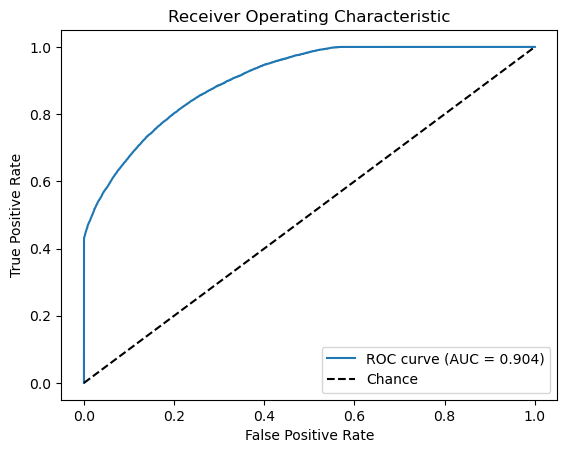

In [11]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Assume y_test, y_proba are already defined
fpr, tpr, _ = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.3f})')
plt.plot([0,1], [0,1], 'k--', label='Chance')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()


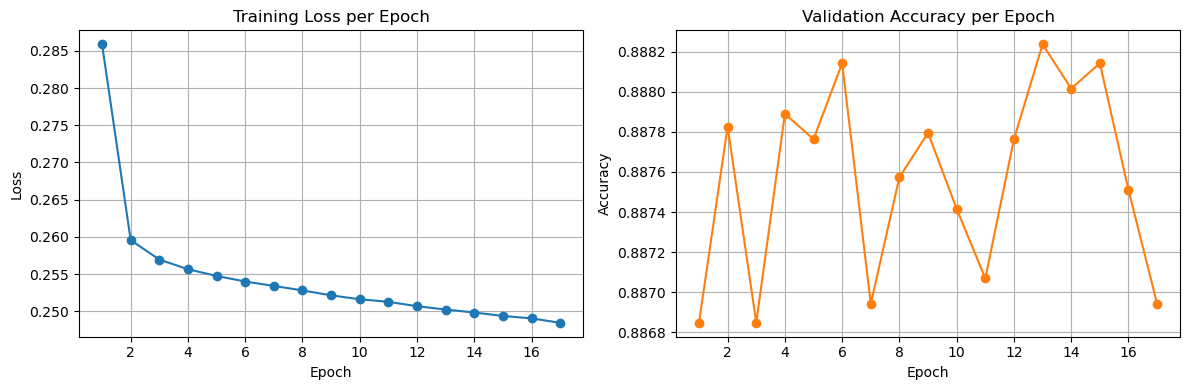

In [12]:
# In[7]: Plot Learning Curves (Loss & Validation Accuracy)

import matplotlib.pyplot as plt

# Extract the trained classifier from your pipeline
mlp = model.named_steps['mlp']

# 1. Training loss curve (one entry per iteration/epoch)
train_loss = mlp.loss_curve_

# 2. Validation accuracy curve (only if early_stopping=True)
#    these are the scores on the held‑out validation split
val_acc = mlp.validation_scores_ if hasattr(mlp, 'validation_scores_') else None

epochs = range(1, len(train_loss) + 1)

# Set up subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# Plot training loss
ax1.plot(epochs, train_loss, marker='o')
ax1.set_title('Training Loss per Epoch')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.grid(True)

# Plot validation accuracy, if available
if val_acc is not None:
    ax2.plot(epochs, val_acc, marker='o', color='tab:orange')
    ax2.set_title('Validation Accuracy per Epoch')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    ax2.grid(True)
else:
    ax2.text(0.5, 0.5, 'No validation\nscores recorded', 
             ha='center', va='center', fontsize=12)
    ax2.set_axis_off()

plt.tight_layout()
plt.show()


In [13]:
from sklearn.metrics import recall_score

# Assuming y_test and y_pred are already defined
recall = recall_score(y_test, y_pred)

print(f"Recall: {recall:.4f}")

Recall: 0.4606


In [14]:
mlp.n_iter_

17

In [15]:
from sklearn.metrics import f1_score
f1 = f1_score(y_test, y_pred)
f1

0.61878405258151

In [16]:
# F1 for the positive class (y = 1)
f1_y1 = f1_score(y_test, y_pred, pos_label=1)

# F1 for the negative class (y = 0)
f1_y0 = f1_score(y_test, y_pred, pos_label=0)

print(f"F1 score for y=1: {f1_y1:.4f}")
print(f"F1 score for y=0: {f1_y0:.4f}")

F1 score for y=1: 0.6188
F1 score for y=0: 0.9348


In [17]:
# Calculate recall for each class

from sklearn.metrics import recall_score

# Option A: specify pos_label explicitly
recall_y1 = recall_score(y_test, y_pred, pos_label=1)
recall_y0 = recall_score(y_test, y_pred, pos_label=0)

print(f"Recall for y=1: {recall_y1:.4f}")
print(f"Recall for y=0: {recall_y0:.4f}")



Recall for y=1: 0.4606
Recall for y=0: 0.9932


In [18]:
from sklearn.metrics import precision_score

# This returns the precision for the positive class (y=1) by default
precision = precision_score(y_test, y_pred)

print(f"Precision: {precision:.4f}")

Precision: 0.9426


## Shapley value Analysis on the Neural Network Model

In [27]:
!pip install shap

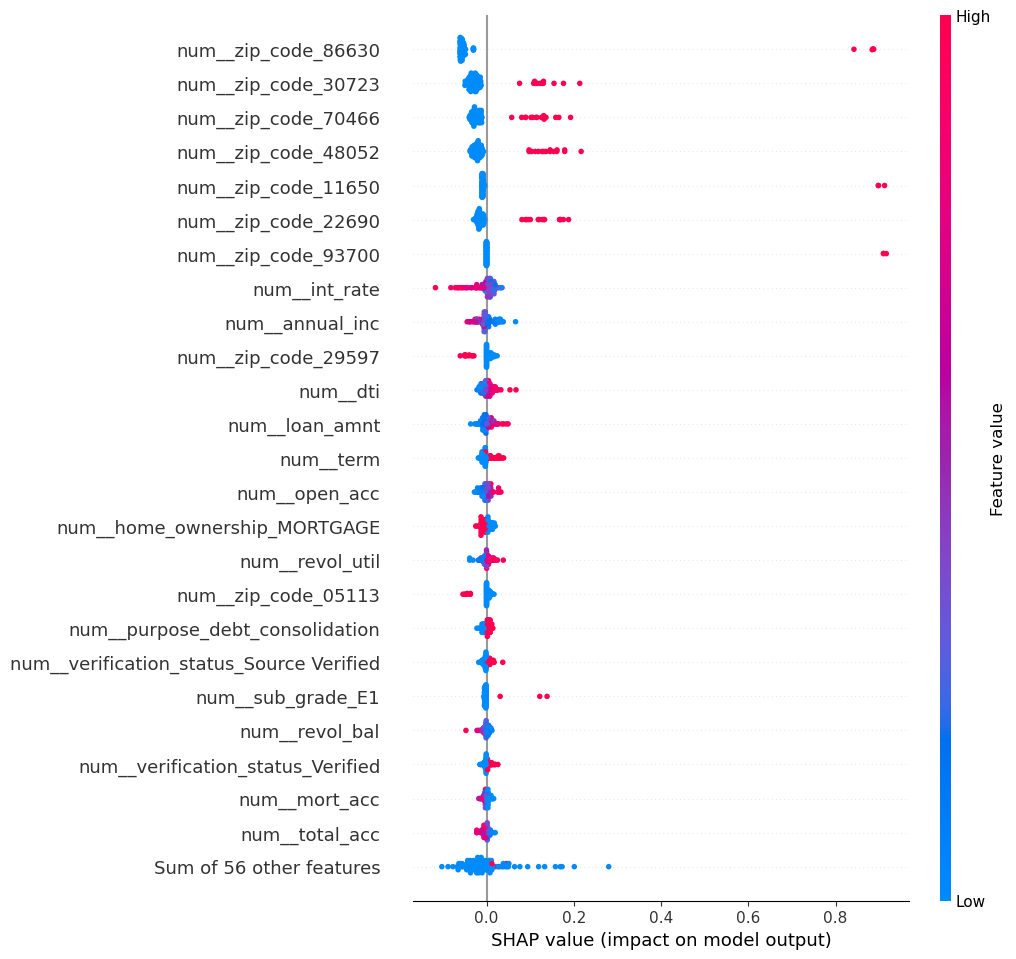

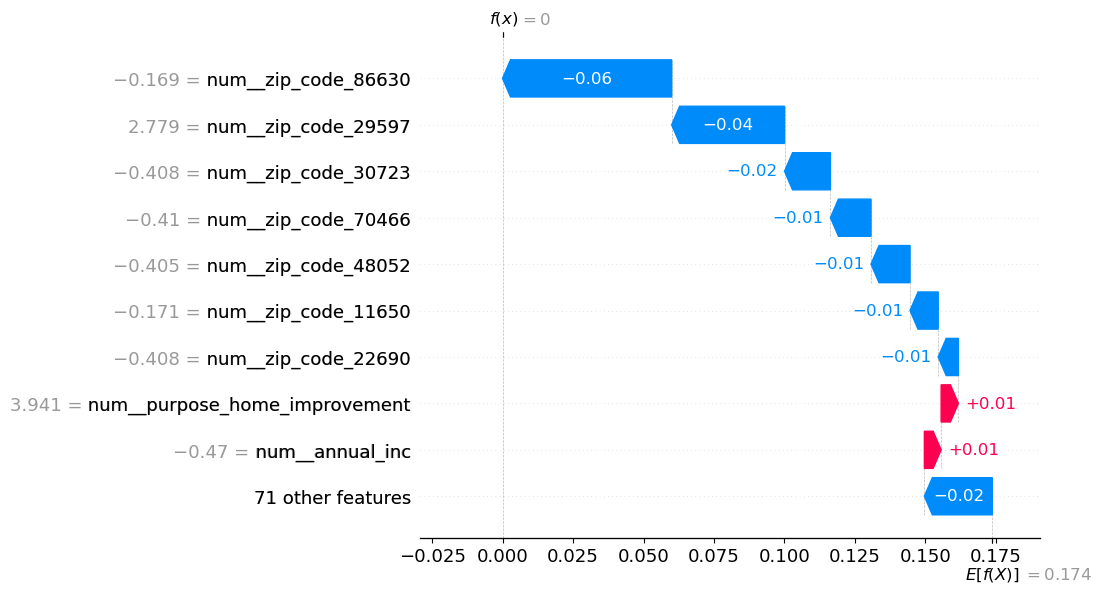

In [26]:
import shap

preproc = model.named_steps["preprocessor"]

X_bg_raw   = X_train.sample(200, random_state=666)
X_bg_proc  = preproc.transform(X_bg_raw)      

X_ex_raw   = X_test.sample(100, random_state=42)
X_ex_proc  = preproc.transform(X_ex_raw)
              

masker    = shap.maskers.Independent(X_bg_proc)
mlp_only  = model.named_steps["mlp"]

explainer = shap.explainers.Permutation(mlp_only.predict_proba,
                                        masker)

sh_values = explainer(X_ex_proc)

ohe = preproc.named_transformers_["cat"].named_steps["onehot"]
feature_names = preproc.get_feature_names_out().tolist()
sh_values.feature_names = feature_names

shap.plots.beeswarm(sh_values[..., 1], max_display=25)
shap.plots.waterfall(sh_values[0, :, 1])

The SHAP analysis shows that the model leans heavily on borrowers’ ZIP codes. Geographic signals can be useful because they bundle latent socio‑economic factors—housing prices, local wages, employment conditions—that genuinely correlate with credit risk. Yet this reliance also raises red flags: it can entrench regional disparities, trigger fairness concerns in regulatory reviews, and weaken generalisation to unseen areas. To curb those risks, treat ZIP as a categorical one‑hot or aggregate it into broader regions (state or CBSA), replace raw codes with engineered socio‑economic indicators such as median income or unemployment, and run disparity tests across ZIP‑based strata.

Encouragingly, classical credit variables still shape predictions in intuitive ways. Higher interest rates, larger loan amounts, elevated debt‑to‑income ratios, longer terms, and greater revolving‑credit utilisation all push default probability up, while higher annual income pulls it down. This pattern suggests the network has internalised legitimate credit logic rather than relying solely on geographic shortcuts, giving the model a sound explanatory backbone once location effects are moderated.

Finally, SHAP waterfall plots translate those complex interactions into borrower‑level narratives. They pinpoint how individual factors—say, a modest loan amount combined with a historically low‑risk ZIP—reduce predicted default odds, while a home‑improvement purpose adds a small increment of risk. Such transparent, quantitative explanations can support underwriters’ decisions and satisfy customer or regulatory disclosure requirements, turning the model’s opaque neural mechanics into actionable insight.